In [ ]:
#!pip install pytesseract

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

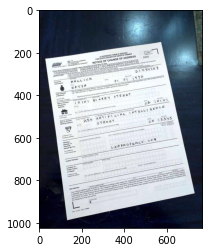

In [8]:
path = r'C:\Users\Clsm\Downloads\Original-Form-2.jpg'
img = cv2.imread(path)
plt.imshow(img)

In [9]:
# get image dimensions
img_height,img_width,channel = img.shape
img_center = (img_width//2, img_height//2) 
print("Image shape : ",img.shape)

# resize
if img_height > 1024 and img_width > 768:
  img = cv2.resize(img, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)
  plt.figure()
  plt.imshow(img)

Image shape :  (1024, 768, 3)


In [10]:
def remove_text(input_img, iterations=3):
    '''Repeated Closing operation to remove text from the document'''  
    kernel = np.ones((5,5),np.uint8)
    output_img = cv2.morphologyEx(input_img, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return output_img

def remove_background(input_img):
    '''remove background using GrabCut'''
    mask = np.zeros(input_img.shape[:2], np.uint8)

    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    rect = (20, 20, input_img.shape[1]-20, input_img.shape[0]-20)

    cv2.grabCut(input_img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    output_img = input_img*mask2[:,:,np.newaxis]

    return output_img

def detect_contour(input_img, keep_contours=3, select_contour=0):
    # Blank canvas
    img_base = np.zeros_like(input_img)

    # Finding contours for the detected edges.
    # contours, hierarchy = cv2.findContours(input_img, cv2.RETR_LIST, cv.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(input_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Keep only the largest detected contours
    largest_con = sorted(contours, key=cv2.contourArea, reverse=True)[:keep_contours]
    output_img = cv2.drawContours(img_base, largest_con, select_contour, (255, 255, 255), 3)
    
    return (contours, largest_con, output_img)

def get_corners(input_img, largest_contours):
    # Blank canvas.
    img_base = np.zeros_like(input_img)
    
    # Loop over the contours.
    for c in largest_contours:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        if len(corners) == 4: # if a rectangle is found, take its c (contour)
            break
        
    output_img = cv2.drawContours(img_base, c, -1, (255, 255, 255), 3) # draw rectangle contour on base image
    output_img = cv2.drawContours(output_img, corners, -1, (255, 0, 255), 15) # draw corner points on base image
    return (corners, output_img)

def order_corner_points(corners):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    corners = np.array(corners)
    s = corners.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[1] = corners[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[3] = corners[np.argmax(s)]
 
    diff = np.diff(corners, axis=1)
    # Top-right point will have the smallest difference.
    rect[0] = corners[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[2] = corners[np.argmax(diff)]
    # Return the ordered coordinates
    return rect.astype('int').tolist()  # return [tr, tl, bl, br]

def get_destination_coordinates(corners_ordered):
    # input corners must be ordered this way (tr, tl, bl, br)

    (tr, tl, bl, br) = corners_ordered

    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    # heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    # heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    heightA = np.sqrt(((tr[1] - br[1]) ** 2) + ((tr[0] - br[0]) ** 2))
    heightB = np.sqrt(((tl[1] - bl[1]) ** 2) + ((tl[0] - bl[0]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Final destination co-ordinates.
    # destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
    destination_corners = [[maxWidth, 0], [0, 0], [0, maxHeight], [maxWidth, maxHeight]] # tr, tl, bl, br

    return (destination_corners, maxWidth, maxHeight)

def show_img(input_img):
    plt.figure(dpi=100)
    plt.imshow(input_img)

In [11]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# img_histeql = cv2.equalizeHist(img_gray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_histeql = clahe.apply(img_gray)

# img_blur = cv2.bilateralFilter(img_gray, 100, 25, 25)  # 100, 25, 25
img_blur = cv2.medianBlur(img_gray, 3)

img_edges = cv2.Canny(img_blur, 0, 20)
# img_edges = cv2.dilate(img_edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# # other filters
# # img_noalpha = cv2.cvtColor(img_histeql, cv2.COLOR_RGBA2RGB)
# # img_removebg = remove_background(img_noalpha)
# # img_notext = remove_text(img_blur, iterations=3)
# # img_binary = cv2.threshold(img_notext, 10, 255, cv2.THRESH_BINARY)[1]

contours, largest_contours, img_contour = detect_contour(img_edges, keep_contours=3, select_contour=0)
corners, img_corners = get_corners(img_contour, largest_contours)

# # corners  # tr, tl, bl, br
corners_ordered = order_corner_points(np.concatenate(corners)) # tr, tl, bl, br
destination_corners, maxWidth, maxHeight = get_destination_coordinates(corners_ordered)

# # transform perspective
M = cv2.getPerspectiveTransform(np.float32(corners_ordered), np.float32(destination_corners)) # Getting the homography
# Perspective transform using homography
img_final = cv2.warpPerspective(img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

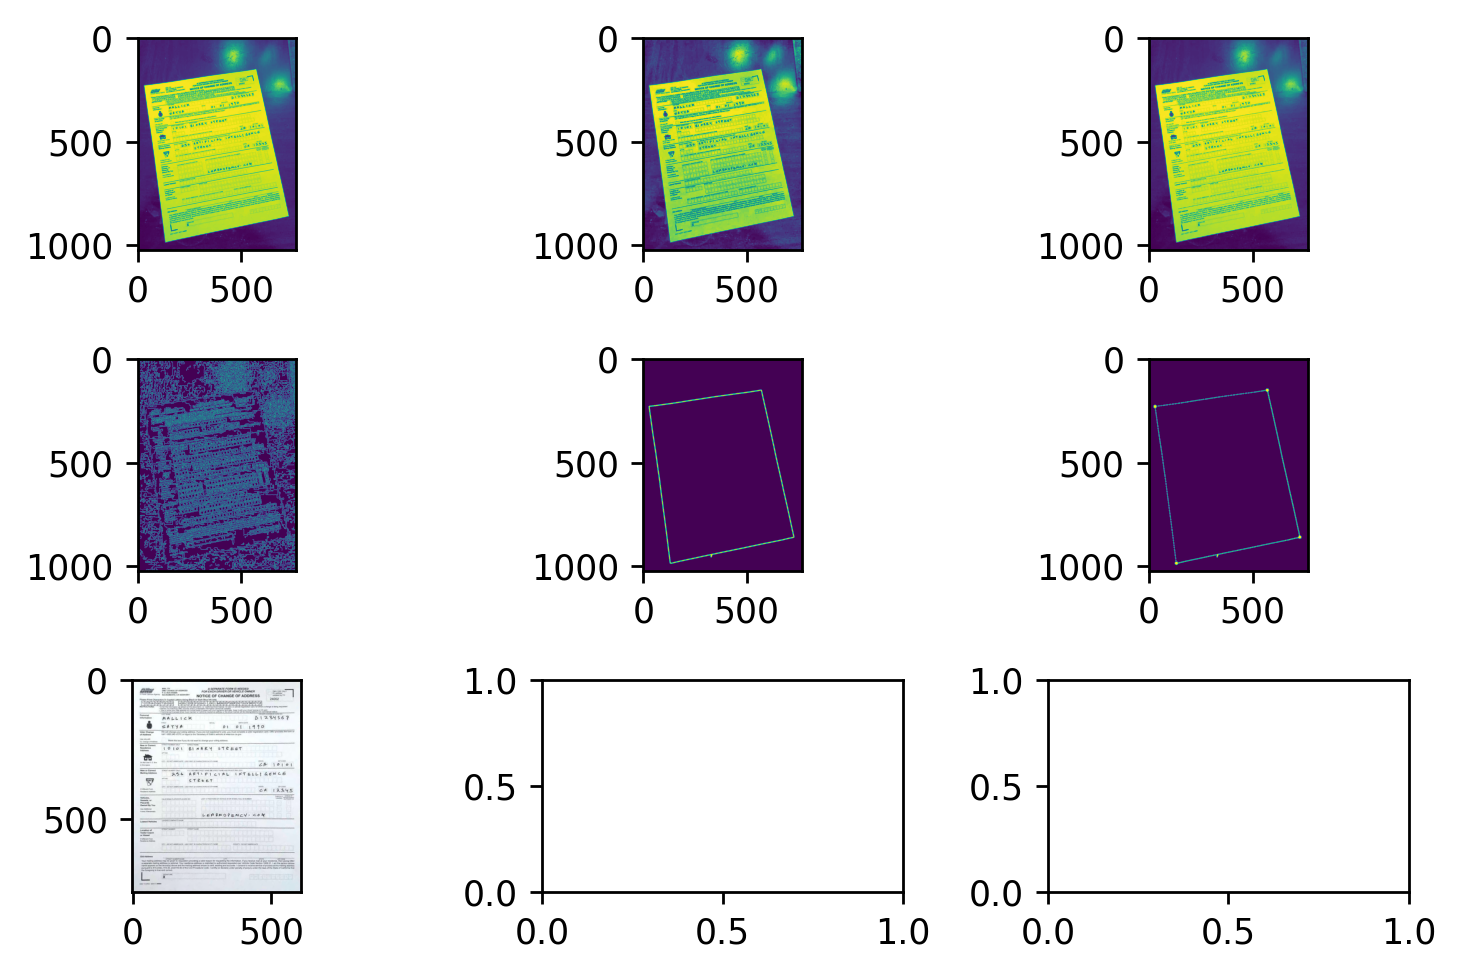

In [12]:
fig, axes = plt.subplots(3,3, dpi=250)
axes[0][0].imshow(img_gray)
axes[0][1].imshow(img_histeql)
axes[0][2].imshow(img_blur)
axes[1][0].imshow(img_edges)
axes[1][1].imshow(img_contour)
axes[1][2].imshow(img_corners)
axes[2][0].imshow(img_final)
plt.tight_layout()

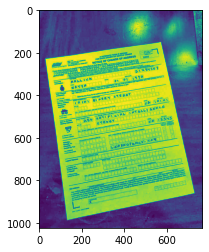

In [3]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(r'C:\Users\Clsm\Downloads\Original-Form-2.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray)
plt.imshow(equalized)